# Import Statements

In [1]:
import numpy as np
import pandas as pd
import math
import cmath
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy

%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import scipy
from scipy import signal

import watermark 

# GPU code

In [ ]:
# This will throw an error if you don't have a GPU

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data Setup for Geo Sim

In [2]:
# File from Luke
samples = np.fromfile(r"C:\Users\henry\Documents\PythonScripts\DoaNN_old\Rand16Q_255", np.complex64) # Read in file.  We have to tell it what format it is

test = np.array(samples)
print(test.shape)

(1000000,)


In [3]:
# Setup for the geometry simulator

# Calculate speed of light to be used in calculating time delay
eps0 = 8.854187817e-12
mu0 = 4*np.pi * 1e-7
c0 = 1/np.sqrt(eps0*mu0)

# Frequencies to be used
fs = 20000000  # sampling frequency
fs1 = 2.45e9  # transmitting frequency
lambda1 = c0/fs1  # Wavelength of transmitting frequency

# Generate RX geometry location
RX = np.zeros(2) 
RX[1] = 0  # Middle RX element y-location
RX[0] = RX[1] + lambda1/2  # Location of top RX element

# Antenna Geometry
horz_elements = 2 # horizontal antenna elements (rows)
vert_elements = 1 # vertical antenna elements (col)
num_elements = horz_elements * vert_elements # number of antenna elements

# creating blank arrays to store the values from the geometry simulator
elements = [[], []] # empty matrix to store each elements data
angleofArrival = [] # empty matrix to store DoA
print(elements) # examples of indexing elements[0][0] = 1, elements[1][2] = 3 

[[], []]


In [4]:
# Reducing the amount of samples from the file from Luke
N = 512 # size of the sample, fft size, 512 and 1000 seemed to give good values
aveN = 500 # averaging the sigal

small_samples = np.zeros(N, complex) # blank array to store the data

# taking samples and reducing the length and getting the data setup for averaging
Tsamples = np.zeros((aveN,N),dtype=complex)
for k in range(aveN):
    for i in range(N):
        Tsamples[k,i] = samples[i+N*k]

# print(small_samples.shape)

# Geo Sim

In [5]:
# Generating the Data for the NN
numberofSamples = 100

for i in range(numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(2)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(2) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(2) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    #FFT and shift magnitude
    fTsamples = np.zeros((aveN,N),dtype=complex)
    for k in range(aveN):
        fTsamples[k,:] = np.fft.fft(Tsamples[k,:],n=N)
        fTsamples[k,:] = np.fft.fftshift(fTsamples[k,:])
    
    # converting the signal into the frequency domain
#     fsmall_samples = np.fft.fft(small_samples)
#     fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    fstemp = 2.44e9

    # Create frequency array around fs1
    fs1 = np.linspace(fstemp-fs/2,fstemp+fs/2,num=N)
    
    # shifting the signal in the frequency domain
    
    shift0 = np.zeros((aveN,N),dtype=complex)
    shift1 = np.zeros((aveN,N),dtype=complex)
    
    for i in range(aveN):
        shift0[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[0])
        shift1[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[1])

        shift0[i,:] = np.fft.ifftshift(shift0[i,:])
        shift1[i,:] = np.fft.ifftshift(shift1[i,:])

        # converting from frequency domain back to time domain
        shift0[i,:] = np.fft.ifft(shift0[i,:])
        shift1[i,:] = np.fft.ifft(shift1[i,:])
    
    # storing the data
    elements[0].append(shift0) # storing the data for element 1
    elements[1].append(shift1) # storing the data for element 2 
    angleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[4.75333637e-11 0.00000000e+00]
[-13.47506166 -13.46226124]


# Verifying Geo Sim Output

In [6]:
# checking the shape and values for element 1
# element1 = np.array(elements[0]) 
# print(element1.shape)

# checking the shape and values for elements
# testEle1 = np.array(elements)
# print(testEle1.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

In [7]:
# checking the shape and values for element 1
# element1 = np.array(elements[1])
# print(element1.shape)

# checking the shape and values for elements
# testEle2 = np.array(elements)
# print(testEle2.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

In [8]:
# checking the shape and values for DoA
ANGLE = np.array(angleofArrival)
print(ANGLE.shape)

# for i in angleofArrival:
#     print(i)

(100,)
11.964837227206912
14.903385340871955
-6.840577371891967
-43.87210259733759
6.536794968265689
-5.3180618814139535
-2.694858074685409
12.112233223080397
-7.730723941382678
12.454373971757922
-0.6727866533313025
10.727228488071509
-9.493900187485059
11.401854547273016
-3.6441857985716077
13.404498726852285
4.739240167308068
-13.171503627650797
9.477675234917372
-9.263322619278476
-4.6145510004400325
9.085654388282084
1.8753612735718654
17.544704936197572
1.816052743576303
-5.018293665836432
-7.07399103706635
-11.701592349406821
5.126894493071282
-10.230119433456368
-13.031165409882458
19.21766949416356
0.9048960297710191
-11.217495875007813
-25.91746202181673
-17.074635277304978
25.475579092869367
-22.22718572417489
11.819380259478686
-28.536853930891567
-10.836160340066538
2.240795099570226
-12.8908644979766
-11.172279209431867
-12.06160250186074
-7.627924204542883
11.547762881908076
37.105229587470895
0.2756457169214327
-0.31242292760729173
7.820475251581645
-29.393391326680238


# Cross Correlation

In [9]:
# Data setup for the correlation and averaging
element1 = np.array(elements[0]) # (number of DoA senarios, aveN, number of samples from signal)
element2 = np.array(elements[1])

test = np.array(element1[0])
print(element1.shape)
print(test.shape)

(100, 500, 512)
(500, 512)


In [10]:
# corr each time step then take the mean
corr = []  # creating a blank array to store the correlations in
avg = []

# Loops through the number of samples
for n in range(numberofSamples):
    # taking the (numberofSamples, aveN, Samples) to (aveN, Samples)
    temp1 = np.array(element1[n])
    temp2 = np.array(element2[n])

    # zero matrix to store the correlations between samples
    S_all = np.zeros(N, dtype=complex)

    # Loops through the aveN
    for i in range(aveN):
        # takes the correlation between element#(n, i, samples)
        temp = signal.correlate(temp1[i], temp2[i], mode='same', method='auto')
        S_all += temp
        
    # averag the magnitudes
    avg.append(S_all/aveN)
        
corr = avg

test = np.array(corr)
print(test.shape)

(100, 512)


# Correlation Output

C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-11-3809f5076924>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


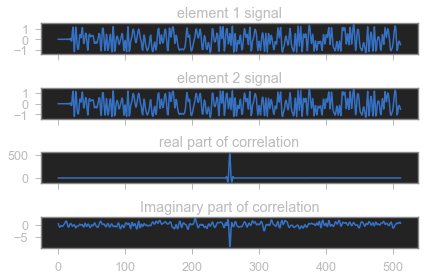

In [11]:
# Plotting the real part of the correlation
corrREAL = np.real(np.array(corr)) # 1&2
corrIMAG = np.imag(np.array(corr)) # 1&2

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_signal1, ax_signal2, ax_corrREAL, ax_corrIMAG) = plt.subplots(4, 1, sharex=True)

# picking a random index to sample from
# sample = randint(0,numberofSamples-1)
sample = 3

# Element 1
ax_signal1.plot(element1[sample][0])
ax_signal1.set_title('element 1 signal')

# Element 2
ax_signal2.plot(element2[sample][0])
ax_signal2.set_title('element 2 signal')

# cross correlation between element 1 and 2, real part
ax_corrREAL.plot(corrREAL[sample])
ax_corrREAL.set_title('real part of correlation')

# cross correlation between element 1 and 2, imag part
ax_corrIMAG.plot(corrIMAG[sample])
ax_corrIMAG.set_title('Imaginary part of correlation')

fig.tight_layout()
fig.show()

# Complex to polar

In [12]:
# Concatinating the real and imag parts of the correlation
realCorr = np.real(np.array(corr))
imagCorr = np.imag(np.array(corr))

# combing the real and imaginary values [real,imag]
complexCorr = np.concatenate((realCorr,imagCorr),axis=-1)
print(complexCorr.shape)

(100, 1024)


In [13]:
# Converting to polar from complex
tempCorr = np.array(corr)
print(tempCorr.shape)

polarCorr = np.concatenate((tempCorr, np.zeros((numberofSamples, N))), axis=-1)
print(polarCorr.shape)

for j in range(numberofSamples):
    for i in range(N):
        temp = abs(tempCorr[j][i])
        temp2 = cmath.phase(tempCorr[j][i])
        polarCorr[j][i] = temp
        polarCorr[j][N+i] = temp2

print('--------------------')
print(polarCorr.shape)
print(polarCorr[0].shape)

polarCorr = np.real(polarCorr)

(100, 512)
(100, 1024)
--------------------
(100, 1024)
(1024,)


# Data for NN

In [14]:
# Setting the label and feature
angleofArrival = np.array(angleofArrival)

train_labels = angleofArrival
train_samples = polarCorr

In [15]:
print(train_samples.shape)

# for i in train_samples:
#     print(i)

(100, 1024)


In [16]:
print(train_labels.shape)

# for i in train_labels:
#     print(i)

(100,)


In [17]:
# scaling the NN between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1)) # testing -1,1 was 0,1

scaled_train_samples = scaler.fit_transform(train_samples)
scaled_train_labels = scaler.fit_transform(train_labels.reshape(-1,1)) #  this is reshaping from (100,) to (100,1)

In [18]:
print(scaled_train_samples.shape)

# for i in scaled_train_samples:
#     print(i)

(100, 1024)


In [19]:
print(scaled_train_labels.shape)

# for i in scaled_train_labels:
#     print(i)

(100, 1)


# Build the NN

In [20]:
# Testing the flatten layer to get output shape
# Create a `Sequential` model and add a Dense layer as the first layer.  
# try different activation, relu isn't symmetric
# map the inputs -45 to 45 to 0 to 1 or something like
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(N*2))) 
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
# model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.output_shape

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [22]:
history = model.fit(
    x=scaled_train_samples,
    y=scaled_train_labels,
    validation_split=0.1,
    batch_size=10,
    epochs=500, 
    verbose=2)

Epoch 1/500
9/9 - 0s - loss: 0.7971 - root_mean_squared_error: 0.8928 - val_loss: 0.7423 - val_root_mean_squared_error: 0.8616
Epoch 2/500
9/9 - 0s - loss: 0.7848 - root_mean_squared_error: 0.8859 - val_loss: 0.7302 - val_root_mean_squared_error: 0.8545
Epoch 3/500
9/9 - 0s - loss: 0.7722 - root_mean_squared_error: 0.8788 - val_loss: 0.7183 - val_root_mean_squared_error: 0.8475
Epoch 4/500
9/9 - 0s - loss: 0.7602 - root_mean_squared_error: 0.8719 - val_loss: 0.7064 - val_root_mean_squared_error: 0.8405
Epoch 5/500
9/9 - 0s - loss: 0.7481 - root_mean_squared_error: 0.8649 - val_loss: 0.6948 - val_root_mean_squared_error: 0.8336
Epoch 6/500
9/9 - 0s - loss: 0.7363 - root_mean_squared_error: 0.8581 - val_loss: 0.6834 - val_root_mean_squared_error: 0.8267
Epoch 7/500
9/9 - 0s - loss: 0.7246 - root_mean_squared_error: 0.8512 - val_loss: 0.6721 - val_root_mean_squared_error: 0.8198
Epoch 8/500
9/9 - 0s - loss: 0.7130 - root_mean_squared_error: 0.8444 - val_loss: 0.6610 - val_root_mean_square

9/9 - 0s - loss: 0.2853 - root_mean_squared_error: 0.5341 - val_loss: 0.2524 - val_root_mean_squared_error: 0.5024
Epoch 66/500
9/9 - 0s - loss: 0.2810 - root_mean_squared_error: 0.5301 - val_loss: 0.2483 - val_root_mean_squared_error: 0.4982
Epoch 67/500
9/9 - 0s - loss: 0.2766 - root_mean_squared_error: 0.5259 - val_loss: 0.2444 - val_root_mean_squared_error: 0.4943
Epoch 68/500
9/9 - 0s - loss: 0.2725 - root_mean_squared_error: 0.5220 - val_loss: 0.2405 - val_root_mean_squared_error: 0.4904
Epoch 69/500
9/9 - 0s - loss: 0.2686 - root_mean_squared_error: 0.5183 - val_loss: 0.2366 - val_root_mean_squared_error: 0.4864
Epoch 70/500
9/9 - 0s - loss: 0.2645 - root_mean_squared_error: 0.5143 - val_loss: 0.2329 - val_root_mean_squared_error: 0.4826
Epoch 71/500
9/9 - 0s - loss: 0.2606 - root_mean_squared_error: 0.5105 - val_loss: 0.2292 - val_root_mean_squared_error: 0.4787
Epoch 72/500
9/9 - 0s - loss: 0.2567 - root_mean_squared_error: 0.5067 - val_loss: 0.2256 - val_root_mean_squared_err

Epoch 129/500
9/9 - 0s - loss: 0.1331 - root_mean_squared_error: 0.3649 - val_loss: 0.1121 - val_root_mean_squared_error: 0.3348
Epoch 130/500
9/9 - 0s - loss: 0.1322 - root_mean_squared_error: 0.3636 - val_loss: 0.1112 - val_root_mean_squared_error: 0.3334
Epoch 131/500
9/9 - 0s - loss: 0.1311 - root_mean_squared_error: 0.3621 - val_loss: 0.1103 - val_root_mean_squared_error: 0.3322
Epoch 132/500
9/9 - 0s - loss: 0.1302 - root_mean_squared_error: 0.3608 - val_loss: 0.1095 - val_root_mean_squared_error: 0.3309
Epoch 133/500
9/9 - 0s - loss: 0.1292 - root_mean_squared_error: 0.3595 - val_loss: 0.1087 - val_root_mean_squared_error: 0.3296
Epoch 134/500
9/9 - 0s - loss: 0.1284 - root_mean_squared_error: 0.3583 - val_loss: 0.1079 - val_root_mean_squared_error: 0.3284
Epoch 135/500
9/9 - 0s - loss: 0.1275 - root_mean_squared_error: 0.3570 - val_loss: 0.1071 - val_root_mean_squared_error: 0.3272
Epoch 136/500
9/9 - 0s - loss: 0.1266 - root_mean_squared_error: 0.3558 - val_loss: 0.1063 - val_

Epoch 193/500
9/9 - 0s - loss: 0.1011 - root_mean_squared_error: 0.3179 - val_loss: 0.0848 - val_root_mean_squared_error: 0.2913
Epoch 194/500
9/9 - 0s - loss: 0.1009 - root_mean_squared_error: 0.3176 - val_loss: 0.0847 - val_root_mean_squared_error: 0.2909
Epoch 195/500
9/9 - 0s - loss: 0.1007 - root_mean_squared_error: 0.3173 - val_loss: 0.0845 - val_root_mean_squared_error: 0.2907
Epoch 196/500
9/9 - 0s - loss: 0.1004 - root_mean_squared_error: 0.3169 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2904
Epoch 197/500
9/9 - 0s - loss: 0.1003 - root_mean_squared_error: 0.3166 - val_loss: 0.0842 - val_root_mean_squared_error: 0.2901
Epoch 198/500
9/9 - 0s - loss: 0.1000 - root_mean_squared_error: 0.3163 - val_loss: 0.0840 - val_root_mean_squared_error: 0.2899
Epoch 199/500
9/9 - 0s - loss: 0.0999 - root_mean_squared_error: 0.3160 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2896
Epoch 200/500
9/9 - 0s - loss: 0.0997 - root_mean_squared_error: 0.3157 - val_loss: 0.0837 - val_

Epoch 257/500
9/9 - 0s - loss: 0.0917 - root_mean_squared_error: 0.3028 - val_loss: 0.0767 - val_root_mean_squared_error: 0.2769
Epoch 258/500
9/9 - 0s - loss: 0.0916 - root_mean_squared_error: 0.3026 - val_loss: 0.0766 - val_root_mean_squared_error: 0.2767
Epoch 259/500
9/9 - 0s - loss: 0.0914 - root_mean_squared_error: 0.3024 - val_loss: 0.0764 - val_root_mean_squared_error: 0.2765
Epoch 260/500
9/9 - 0s - loss: 0.0913 - root_mean_squared_error: 0.3022 - val_loss: 0.0763 - val_root_mean_squared_error: 0.2763
Epoch 261/500
9/9 - 0s - loss: 0.0912 - root_mean_squared_error: 0.3020 - val_loss: 0.0762 - val_root_mean_squared_error: 0.2760
Epoch 262/500
9/9 - 0s - loss: 0.0910 - root_mean_squared_error: 0.3017 - val_loss: 0.0761 - val_root_mean_squared_error: 0.2758
Epoch 263/500
9/9 - 0s - loss: 0.0909 - root_mean_squared_error: 0.3015 - val_loss: 0.0759 - val_root_mean_squared_error: 0.2756
Epoch 264/500
9/9 - 0s - loss: 0.0908 - root_mean_squared_error: 0.3013 - val_loss: 0.0758 - val_

Epoch 321/500
9/9 - 0s - loss: 0.0827 - root_mean_squared_error: 0.2876 - val_loss: 0.0677 - val_root_mean_squared_error: 0.2602
Epoch 322/500
9/9 - 0s - loss: 0.0825 - root_mean_squared_error: 0.2873 - val_loss: 0.0676 - val_root_mean_squared_error: 0.2599
Epoch 323/500
9/9 - 0s - loss: 0.0824 - root_mean_squared_error: 0.2870 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2596
Epoch 324/500
9/9 - 0s - loss: 0.0822 - root_mean_squared_error: 0.2868 - val_loss: 0.0672 - val_root_mean_squared_error: 0.2593
Epoch 325/500
9/9 - 0s - loss: 0.0821 - root_mean_squared_error: 0.2865 - val_loss: 0.0671 - val_root_mean_squared_error: 0.2590
Epoch 326/500
9/9 - 0s - loss: 0.0819 - root_mean_squared_error: 0.2862 - val_loss: 0.0669 - val_root_mean_squared_error: 0.2587
Epoch 327/500
9/9 - 0s - loss: 0.0817 - root_mean_squared_error: 0.2859 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2583
Epoch 328/500
9/9 - 0s - loss: 0.0816 - root_mean_squared_error: 0.2856 - val_loss: 0.0666 - val_

Epoch 385/500
9/9 - 0s - loss: 0.0712 - root_mean_squared_error: 0.2669 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2366
Epoch 386/500
9/9 - 0s - loss: 0.0710 - root_mean_squared_error: 0.2665 - val_loss: 0.0558 - val_root_mean_squared_error: 0.2361
Epoch 387/500
9/9 - 0s - loss: 0.0708 - root_mean_squared_error: 0.2661 - val_loss: 0.0556 - val_root_mean_squared_error: 0.2357
Epoch 388/500
9/9 - 0s - loss: 0.0706 - root_mean_squared_error: 0.2658 - val_loss: 0.0554 - val_root_mean_squared_error: 0.2353
Epoch 389/500
9/9 - 0s - loss: 0.0704 - root_mean_squared_error: 0.2654 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2348
Epoch 390/500
9/9 - 0s - loss: 0.0702 - root_mean_squared_error: 0.2650 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2344
Epoch 391/500
9/9 - 0s - loss: 0.0700 - root_mean_squared_error: 0.2646 - val_loss: 0.0547 - val_root_mean_squared_error: 0.2339
Epoch 392/500
9/9 - 0s - loss: 0.0698 - root_mean_squared_error: 0.2642 - val_loss: 0.0545 - val_

Epoch 449/500
9/9 - 0s - loss: 0.0578 - root_mean_squared_error: 0.2404 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2054
Epoch 450/500
9/9 - 0s - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2049
Epoch 451/500
9/9 - 0s - loss: 0.0574 - root_mean_squared_error: 0.2395 - val_loss: 0.0418 - val_root_mean_squared_error: 0.2044
Epoch 452/500
9/9 - 0s - loss: 0.0572 - root_mean_squared_error: 0.2391 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2039
Epoch 453/500
9/9 - 0s - loss: 0.0570 - root_mean_squared_error: 0.2387 - val_loss: 0.0413 - val_root_mean_squared_error: 0.2033
Epoch 454/500
9/9 - 0s - loss: 0.0567 - root_mean_squared_error: 0.2382 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2028
Epoch 455/500
9/9 - 0s - loss: 0.0565 - root_mean_squared_error: 0.2378 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2022
Epoch 456/500
9/9 - 0s - loss: 0.0563 - root_mean_squared_error: 0.2374 - val_loss: 0.0407 - val_

In [23]:
# The list of epochs is stored separately from the rest of history.
epochs = history.epoch

# Gather the history (a snapshot) of each epoch.
hist = pd.DataFrame(history.history)

# Specifically gather the model's root mean squared error at each epoch.
rmse = hist["root_mean_squared_error"]

# Test Data (same as cells 2-7 but merged)

In [24]:
# Might want to combine with the training data generation

In [25]:
# Setup for Geo Sim
test_elements = [[], []]
test_AngleofArrival = []

In [26]:
# Geo Sim
test_numberofSamples = numberofSamples # amount of test cases

for i in range(test_numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(2)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(2) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(2) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    #FFT and shift magnitude
    fTsamples = np.zeros((aveN,N),dtype=complex)
    for k in range(aveN):
        fTsamples[k,:] = np.fft.fft(Tsamples[k,:],n=N)
        fTsamples[k,:] = np.fft.fftshift(fTsamples[k,:])
    
#     # converting the signal into the frequency domain
#     fsmall_samples = np.fft.fft(small_samples)
#     fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    fstemp = 2.44e9

    # Create frequency array around fs1
    fs1 = np.linspace(fstemp-fs/2,fstemp+fs/2,num=N)
    
    # shifting the signal in the frequency domain
    
    shift0 = np.zeros((aveN,N),dtype=complex)
    shift1 = np.zeros((aveN,N),dtype=complex)
    for i in range(aveN):
        shift0[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[0])
        shift1[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[1])

        shift0[i,:] = np.fft.ifftshift(shift0[i,:])
        shift1[i,:] = np.fft.ifftshift(shift1[i,:])

        # converting from frequency domain back to time domain
        shift0[i,:] = np.fft.ifft(shift0[i,:])
        shift1[i,:] = np.fft.ifft(shift1[i,:])
    
    # storing the data
    test_elements[0].append(shift0) # storing the data for element 1
    test_elements[1].append(shift0) # storing the data for element 2 
    test_AngleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[6.60619088e-11 0.00000000e+00]
[-18.89382895 -18.88024384]


In [27]:
# Data setup for the correlation and averaging
test_element1 = np.array(test_elements[0]) # (number of DoA senarios, aveN, number of samples from signal)
test_element2 = np.array(test_elements[1])

test = np.array(test_element1[0])
print(test_element1.shape)
print(test.shape)

(100, 500, 512)
(500, 512)


In [28]:
# corr each time step then take the mean
test_corr = []  # creating a blank array to store the correlations in
test_avg = []

# Loops through the number of samples
for n in range(test_numberofSamples):
    # taking the (numberofSamples, aveN, Samples) to (aveN, Samples)
    temp1 = np.array(test_element1[n])
    temp2 = np.array(test_element2[n])

    # zero matrix to store the correlations between samples
    test_S_all = np.zeros(N, dtype=complex)

    # Loops through the aveN
    for i in range(aveN):
        # takes the correlation between element#(n, i, samples)
        temp = signal.correlate(temp1[i], temp2[i], mode='same', method='auto')
        test_S_all += temp
        
    # averag the magnitudes
    test_avg.append(test_S_all/aveN)
        
test_corr = test_avg

test = np.array(test_corr)
print(test.shape)

(100, 512)


In [29]:
# Converting to polar from complex
tempCorr = np.array(test_corr)
print(tempCorr.shape)

test_polarCorr = np.concatenate((tempCorr, np.zeros((test_numberofSamples, N))), axis=-1)
print(test_polarCorr.shape)

for j in range(test_numberofSamples):
    for i in range(N):
        temp = abs(tempCorr[j][i])
        temp2 = cmath.phase(tempCorr[j][i])
        test_polarCorr[j][i] = temp
        test_polarCorr[j][N+i] = temp2

print('--------------------')
print(test_polarCorr.shape)
print(test_polarCorr[0].shape)

test_polarCorr = np.real(test_polarCorr)

(100, 512)
(100, 1024)
--------------------
(100, 1024)
(1024,)


In [30]:
# Setting the label and feature
test_angleofArrival = np.array(test_AngleofArrival)

test_labels = test_angleofArrival
test_samples = test_polarCorr

In [31]:
# scaling the NN between -1 and 1
scaler = MinMaxScaler(feature_range=(-1,1)) # testing -1,1 was 0,1

scaled_test_samples = scaler.fit_transform(test_samples)
scaled_test_labels = scaler.fit_transform(test_labels.reshape(-1,1)) #  this is reshaping from (100,) to (100,1)

# Predict

In [32]:
predictions = model.predict(x=scaled_test_samples, batch_size=1, verbose=0)
testMaxAngle = max(test_AngleofArrival)
testMinAngle = min(test_AngleofArrival)

scaler = MinMaxScaler(feature_range=(testMinAngle,testMaxAngle))

In [33]:
for i in predictions:
    print(i)

[-0.02346]
[-0.03363043]
[-0.02346]
[-0.0220927]
[-0.01580771]
[-0.02346]
[-0.00068288]
[-0.04119699]
[-0.02346]
[-0.02346]
[-0.02346]
[-0.02346]
[-0.02346]
[-0.02638956]
[-0.02346]
[-0.01513592]
[-0.02346]
[-0.0269621]
[-0.00709129]
[-0.02720182]
[-0.02346]
[-0.01491186]
[-0.02517618]
[-0.02324368]
[-0.02346]
[-0.03117906]
[-0.01676975]
[-0.02505773]
[-0.02346]
[-0.02346]
[-0.02717309]
[-0.01775846]
[-0.02346]
[-0.02346]
[-0.02859457]
[-0.02023064]
[-0.02346]
[-0.02346]
[-0.02346]
[-0.02325513]
[-0.03258008]
[-0.0309867]
[-0.02346]
[-0.0158398]
[-0.02346]
[-0.02346]
[-0.02319633]
[-0.03427398]
[-0.01104652]
[-0.02346]
[-0.01817264]
[-0.02346]
[-0.02346]
[-0.02346]
[-0.01663244]
[-0.0359536]
[-0.02346]
[-0.02346]
[-0.0328723]
[-0.02750537]
[-0.01584995]
[-0.02346]
[-0.03247933]
[-0.01867059]
[-0.02346]
[-0.02423541]
[-0.02346]
[-0.01344721]
[-0.03012899]
[-0.02346]
[-0.02346]
[-0.02757991]
[-0.01935703]
[-0.02346]
[-0.02268183]
[-0.02346]
[-0.02346]
[-0.02346]
[-0.02346]
[-0.03047042]


In [34]:
for i in scaled_test_labels:
    print(i)

[0.22148739]
[-0.08747894]
[0.55769311]
[0.08855525]
[-0.24842521]
[0.49140048]
[-0.3548268]
[-0.21035902]
[0.78921322]
[0.56579837]
[0.25027304]
[0.15160256]
[0.63816133]
[-0.35842988]
[0.30404687]
[-0.59097437]
[0.22007884]
[-0.13084799]
[-0.07127238]
[0.02995155]
[0.4358894]
[0.12384689]
[0.07737491]
[-0.34094844]
[0.17602527]
[-0.21254893]
[-0.05160472]
[-0.0108623]
[0.13243066]
[0.41578048]
[-1.]
[-0.21816803]
[0.66783845]
[0.44884762]
[-0.10548621]
[-0.45308932]
[0.20157481]
[1.]
[0.16956108]
[-0.28781218]
[-0.06970292]
[-0.69977275]
[0.88743946]
[-0.76829808]
[0.23961684]
[0.21932643]
[0.07969632]
[-0.35528383]
[-0.18042118]
[0.36342283]
[-0.22689962]
[0.39731336]
[0.67555207]
[0.69517586]
[-0.03681725]
[-0.21002011]
[0.28218274]
[0.69174965]
[-0.01477942]
[-0.22360986]
[-0.51446514]
[0.36750039]
[-0.15303557]
[0.05915946]
[0.92361002]
[-0.19029969]
[0.64508935]
[-0.07190981]
[-0.27085552]
[0.22534557]
[0.36137741]
[-0.12395098]
[-0.28255456]
[0.41371859]
[0.03295187]
[0.5646164

In [35]:
max(predictions)

array([-0.00068288], dtype=float32)

In [36]:
min(predictions)

array([-0.04119699], dtype=float32)

# Plotting Setup

In [37]:
# # not sure if I need this cell, got it from Luke
# trained_weight = model.get_weights()[0]
# trained_bias = model.get_weights()[1]

# epochs = history.epoch
# hist = pd.DataFrame(history.history)
# rmse = hist["root_mean_squared_error"]

In [38]:
def plot_the_loss_curve(epochs, rmse):
    """Plot the loss curve, which shows loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.title('Loss Curve')
    plt.legend()
    plt.ylim([rmse.min()*0.97, rmse.max()])
    plt.xscale("log")
#     plt.yscale("log")
    plt.show()

# Plotting RMSE and Predictions

In [39]:
# plotting the RMSE vs epochs
plot_the_loss_curve(epochs, rmse)

In [ ]:
# check for sign errors
# run for more ep

In [40]:
# scaling my output, I think I am doing this wrong, i should use getWeights or something
scaled_predictions = scaler.fit_transform(predictions)

# changing predictions to (100,) from (100,1) so it can sorted
new_predictions = predictions.reshape((numberofSamples,))
scaled_new_predictions = scaled_predictions.reshape((numberofSamples,))

# sorting the predictions
new_predictions.sort()
scaled_new_predictions.sort()

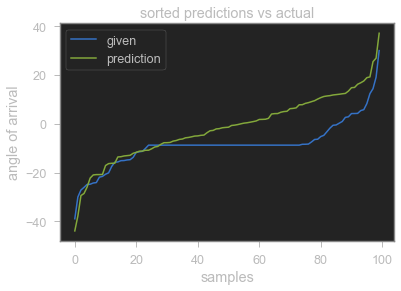

In [41]:
# plot_the_model
# plt.plot(new_predictions)
plt.plot(scaled_new_predictions)
plt.plot(np.sort(train_labels))
plt.xlabel("samples")
plt.ylabel("angle of arrival")
plt.title('sorted predictions vs actual')
plt.legend(('given','prediction')) # swap these

# Water Mark

In [42]:
%load_ext watermark

%watermark -v -m -p math

CPython 3.8.3
IPython 7.18.1

math unknown

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 11, GenuineIntel
CPU cores  : 8
interpreter: 64bit
